# Libraries

##  Remove warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
import tensorflow 
from   tensorflow.keras.metrics                 import *
from   tensorflow.keras.optimizers              import *
from   tensorflow.keras.callbacks               import *
from   tensorflow.keras.layers                  import *
from   tensorflow.keras.models                  import *

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.plot_scatter       import *

# Parameters

## CUDA

In [3]:
try:
    gpus = tensorflow.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tensorflow.config.experimental.set_memory_growth(gpu, True)

            logical_gpus = tensorflow.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

        except RuntimeError as e:

            # Memory growth must be set before GPUs have been initialized
            print(e)
except:
    print('[INFO] Not GPU found')

[INFO] Not GPU found


## Data handling parameters

In [4]:
# Parameters
#
filename        = 'metadata/7-kanal-1.csv'
#
Transformation  = True
Scaling         = 'Robust'

## Neural networks parameters

In [5]:
Lag        =   12
Horizon    =    6
#
epochs     =  200
batch_size =   16

# Data handling

## Import data


In [6]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.18 seconds


,Date,PM2.5,PM10,NO2,CO
0,2022-01-27 16:12:40,0.5,0.5,75.0,298.0
1,2022-01-27 16:12:56,0.5,0.5,75.0,298.0
2,2022-01-27 16:13:13,0.5,0.5,76.0,298.0


## Preprocess data

### Set index

In [7]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


df = df.resample('5min').mean().interpolate()
df = pd.DataFrame( df[ ['PM2.5'] ] )


df.head(3)

,PM2.5
Date,
2022-01-27 16:10:00,0.477778
2022-01-27 16:15:00,0.463158
2022-01-27 16:20:00,0.715789


In [8]:
targetSeries = df.columns[-1]

## Include MA-based features

In [9]:
df['MA6']  = df[ targetSeries ].rolling(6).mean()
df['MA12'] = df[ targetSeries ].rolling(12).mean()
#
# df['MA5'] = df[ targetSeries ].rolling(5).mean()
# df['MA9'] = df[ targetSeries ].rolling(9).mean()

### Split Training/Testing

In [10]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ].dropna()
df_test  = df[ idx: ].dropna()

### Visualization

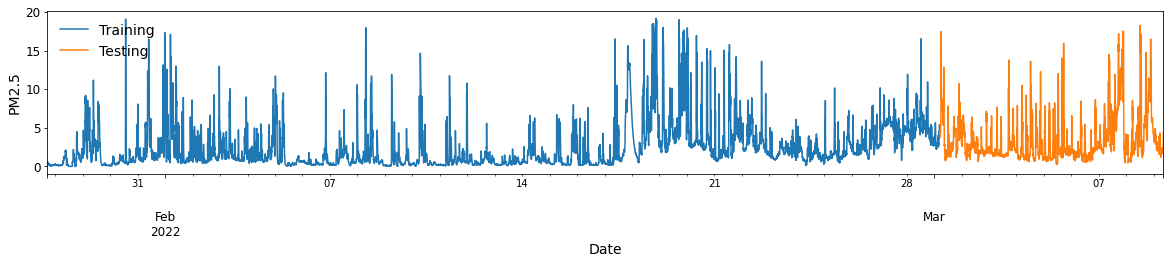

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3) )

df_train[ targetSeries ].plot(ax=ax, color='tab:blue' )
df_test[ targetSeries ].plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.ylabel(targetSeries, size = 14)
plt.xlabel('Date', size = 14);
plt.xticks(size = 12);
plt.yticks(size = 12);

### Fixing Lag

In [12]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Preprocessing

## Data Transformation

In [13]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = max(df.min().min(), 1.0)
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)
    
else:
    print('[INFO] No data transformation applied.')  

[INFO] Data transformation applied


In [14]:
if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    for feature in df.columns:
        if (feature == targetSeries): continue
        print('Feature: ', feature)        
        # Set scaler
        #
        scaler = MinMaxScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = MinMaxScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
            
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    for feature in df.columns:
        if (feature == targetSeries): continue
        print('Feature: ', feature)        
        # Set scaler
        #
        scaler = RobustScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = RobustScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')

    for feature in df.columns:
        if (feature == targetSeries): continue
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = StandardScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = StandardScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
           
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   
    
    for feature in df.columns:
        if (feature == targetSeries): continue
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = StandardScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = StandardScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )  

[INFO] Scaling: Robust
Feature:  MA6
Feature:  MA12


## Create Training/Testing data

In [15]:
def create_dataset(df = None, Lag = 1, Horizon = 12, targetSeries = None, includeLagData = False, includeDate = False, overlap = 1):
    
    if (targetSeries is None):
        targetSeries = df.columns[-1]
    
    dataX, dataY = [], []
    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):
        
        # Original data
        data       = df.to_numpy()[i+1:(i+Lag)]        

        # Include date info
        if (includeDate):            
            myDate = [ np.sin(df[i+1:(i+Lag-1)].index.hour + df[i+1:(i+Lag-1)].index.minute / 60 ).tolist(), 
                       np.cos(df[i+1:(i+Lag-1)].index.hour + df[i+1:(i+Lag-1)].index.minute / 60 ).tolist() ]
            myDate = np.asarray( myDate ).T
            #
            # Concatenate data            
            data = np.concatenate([data, myDate], axis = -1)

        # data_diff: Lag-d differences
        if (includeLagData):
            data_diff  = (df.iloc[i+Lag-1] - df.iloc[i:(i+Lag-1)]).to_numpy()
            #
            # Concatenate data
            data = np.concatenate([data, data_diff], axis = -1)
            
        # Concatenate data
        dataX.append( data )
        
        # Targets
        dataY.append( df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon] )
        
        
    return ( np.array(dataX), np.array(dataY) )

In [16]:
trainX, trainY = create_dataset(df             = df_train, 
                                Lag            = Lag, 
                                Horizon        = Horizon, 
                                targetSeries   = targetSeries,
                                includeLagData = False,
                                includeDate    = False,
                                overlap        = Horizon)
                               

testX,  testY  = create_dataset(df             = df_test, 
                                Lag            = Lag, 
                                Horizon        = Horizon, 
                                targetSeries   = targetSeries,
                                includeLagData = False,
                                includeDate    = False,
                                overlap        = Horizon)


print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|██████████| 390/390 [00:00<00:00, 66169.60it/s]

Training instances:     1558
Testing instances:       390


In [17]:
trainX.shape, trainY.shape

((1558, 11, 3), (1558, 6))

# Forecasting model: Seq2Seq LSTM

In [18]:
import random, os
seed = 42
    
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tensorflow.random.set_seed(seed)

## Setup model

In [19]:
import tensorflow.keras.backend as K

def QuantileLoss(y_true, y_pred, q):

#     q = tf.constant(np.array([q]), dtype=tf.float32)
    e = y_true - y_pred
    v = tensorflow.maximum(q*e, (q-1)*e)
    return K.mean(v)


In [20]:
from tensorflow.keras.regularizers import l2

# Inputs
#
Inputs = Input(shape = (trainX.shape[1], trainX.shape[2]))


# Encoder
#
Encoder = LSTM(units       = 100, 
               activation  ='relu', 
               input_shape = (testX.shape[1], testX.shape[2]), 
               #
               kernel_regularizer    = l2(0.01), 
               recurrent_regularizer = l2(0.01), 
               bias_regularizer      = l2(0.01),
               # 
               return_sequences = True)( Inputs )
Encoder = LSTM(64, activation='relu')(Encoder)
#
# Decoder
#
Decoder = RepeatVector( Horizon )(Encoder)
#
Decoder = LSTM(64, activation='relu', return_sequences=True)(Decoder)
Decoder = LSTM(units       = 100, 
               activation  ='relu', 
               #
               kernel_regularizer    = l2(0.01), 
               recurrent_regularizer = l2(0.01), 
               bias_regularizer      = l2(0.01),
               # 
               )(Decoder)

# Output
#
Outputs1 =  Dense( Horizon, activation='linear' )( Decoder )
Outputs2 =  Dense( Horizon, activation='linear' )( Decoder )
Outputs3 =  Dense( Horizon, activation='linear' )( Decoder )

# Create model
#
model = Model(inputs = Inputs, outputs = [Outputs1, Outputs2, Outputs3])

## Training parameters

In [21]:
# Define metrics
#
metrics = [
            MeanAbsoluteError(name = "MAE", dtype = None),
            RootMeanSquaredError(name = 'RMSE', dtype = None),
          ]


model.compile(loss        = [lambda y_true, y_pred: QuantileLoss(y_true, y_pred, 0.9),
                             'mse',
                             lambda y_true, y_pred: QuantileLoss(y_true, y_pred, 0.1)],
              loss_weights = [0.25, 0.5, 0.25],
              optimizer = Adam(learning_rate = 5.e-4), 
              metrics   = metrics)

In [22]:
# Checkpoint
#
checkpoint = ModelCheckpoint("models/Best.hdf5", 
                              monitor        = 'val_loss', 
                              verbose        = 0, 
                              save_best_only = True, 
                              mode           = 'min')

# Earlystopping
earlystopping = EarlyStopping(monitor       = 'val_loss', 
                              mode          = 'min', 
                              verbose       = 1, 
                              patience      = 10)

# Learning rate adjustment
#
lrs_scheduler  = ReduceLROnPlateau(monitor     = 'val_loss', 
                                   factor      = 0.5,
                                   patience    = 5)

## Training process

In [23]:
# Start clock
#
start = time.time()


score = model.fit(trainX, [trainY, trainY, trainY],
                  epochs          = epochs, 
                  batch_size      = batch_size, 
                  callbacks       = [checkpoint, earlystopping, lrs_scheduler],
                  verbose         = True, 
                  validation_data = (testX, [testY, testY, testY]))


# Terminate clock
#
stop = time.time()
print('[INFO] Time %.2f' % (stop - start))

Train on 1558 samples, validate on 390 samples
Epoch 1/200
1558/1558 [==============================] - 18s 11ms/sample - loss: 3.8416 - dense_loss: 0.2450 - dense_1_loss: 0.3481 - dense_2_loss: 0.1557 - dense_MAE: 0.5318 - dense_RMSE: 0.6520 - dense_1_MAE: 0.4527 - dense_1_RMSE: 0.5915 - dense_2_MAE: 0.5701 - dense_2_RMSE: 0.7620 - val_loss: 2.7416 - val_dense_loss: 0.1404 - val_dense_1_loss: 0.2149 - val_dense_2_loss: 0.0820 - val_dense_MAE: 0.3878 - val_dense_RMSE: 0.5020 - val_dense_1_MAE: 0.3397 - val_dense_1_RMSE: 0.4683 - val_dense_2_MAE: 0.7995 - val_dense_2_RMSE: 1.0010
Epoch 2/200
1558/1558 [==============================] - 7s 5ms/sample - loss: 2.3048 - dense_loss: 0.1038 - dense_1_loss: 0.1921 - dense_2_loss: 0.0704 - dense_MAE: 0.5661 - dense_RMSE: 0.6659 - dense_1_MAE: 0.3134 - dense_1_RMSE: 0.4372 - dense_2_MAE: 0.5641 - dense_2_RMSE: 0.7822 - val_loss: 2.0104 - val_dense_loss: 0.0973 - val_dense_1_loss: 0.1975 - val_dense_2_loss: 0.0698 - val_dense_MAE: 0.5749 - val_de

1558/1558 [==============================] - 7s 4ms/sample - loss: 0.1071 - dense_loss: 0.0753 - dense_1_loss: 0.1248 - dense_2_loss: 0.0460 - dense_MAE: 0.4246 - dense_RMSE: 0.5095 - dense_1_MAE: 0.2291 - dense_1_RMSE: 0.3490 - dense_2_MAE: 0.3624 - dense_2_RMSE: 0.5129 - val_loss: 0.1086 - val_dense_loss: 0.0732 - val_dense_1_loss: 0.1217 - val_dense_2_loss: 0.0535 - val_dense_MAE: 0.3808 - val_dense_RMSE: 0.4584 - val_dense_1_MAE: 0.2374 - val_dense_1_RMSE: 0.3523 - val_dense_2_MAE: 0.5026 - val_dense_2_RMSE: 0.6232
Epoch 32/200
1558/1558 [==============================] - 7s 4ms/sample - loss: 0.1036 - dense_loss: 0.0726 - dense_1_loss: 0.1198 - dense_2_loss: 0.0478 - dense_MAE: 0.4357 - dense_RMSE: 0.5127 - dense_1_MAE: 0.2344 - dense_1_RMSE: 0.3465 - dense_2_MAE: 0.3776 - dense_2_RMSE: 0.5234 - val_loss: 0.1013 - val_dense_loss: 0.0728 - val_dense_1_loss: 0.1138 - val_dense_2_loss: 0.0506 - val_dense_MAE: 0.4455 - val_dense_RMSE: 0.5194 - val_dense_1_MAE: 0.2271 - val_dense_1_RMS

1558/1558 [==============================] - 7s 5ms/sample - loss: 0.0878 - dense_loss: 0.0700 - dense_1_loss: 0.1117 - dense_2_loss: 0.0418 - dense_MAE: 0.4150 - dense_RMSE: 0.4989 - dense_1_MAE: 0.2164 - dense_1_RMSE: 0.3342 - dense_2_MAE: 0.3338 - dense_2_RMSE: 0.4829 - val_loss: 0.0921 - val_dense_loss: 0.0714 - val_dense_1_loss: 0.1133 - val_dense_2_loss: 0.0493 - val_dense_MAE: 0.4806 - val_dense_RMSE: 0.5505 - val_dense_1_MAE: 0.2336 - val_dense_1_RMSE: 0.3396 - val_dense_2_MAE: 0.3825 - val_dense_2_RMSE: 0.5079
Epoch 62/200
1558/1558 [==============================] - 7s 5ms/sample - loss: 0.0877 - dense_loss: 0.0701 - dense_1_loss: 0.1127 - dense_2_loss: 0.0424 - dense_MAE: 0.4114 - dense_RMSE: 0.4984 - dense_1_MAE: 0.2153 - dense_1_RMSE: 0.3342 - dense_2_MAE: 0.3320 - dense_2_RMSE: 0.4804 - val_loss: 0.0916 - val_dense_loss: 0.0713 - val_dense_1_loss: 0.1123 - val_dense_2_loss: 0.0496 - val_dense_MAE: 0.4239 - val_dense_RMSE: 0.4962 - val_dense_1_MAE: 0.2263 - val_dense_1_RMS

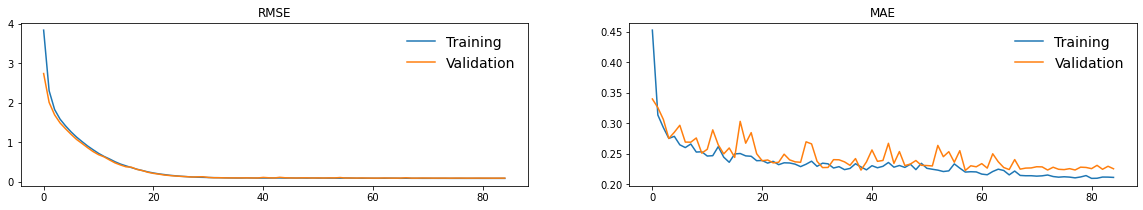

In [24]:
# Create figure
#
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 3) )

# Plot RMSE
#
ax[0].plot( score.history['loss']);
ax[0].plot( score.history['val_loss']);
ax[0].legend(['Training', 'Validation'], frameon = False, fontsize = 14);
ax[0].set_title('RMSE');

# Plot RMSE
#
ax[1].plot( score.history['dense_1_MAE']);
ax[1].plot( score.history['val_dense_1_MAE']);
ax[1].legend(['Training', 'Validation'], frameon = False, fontsize = 14);
ax[1].set_title('MAE');

## Load optimized model

In [25]:
# Load the best model
#
model.load_weights('models/Best.hdf5')

print('[INFO] Model loaded')

[INFO] Model loaded


## Evaluation

### Get predictions

In [26]:
# Get predictions
#
pred = model.predict( testX )

### Apply inverse scaling/transformation

In [27]:
# Apply inverse scaling
#
for i in range( Horizon ):
    testY[:,  i]    = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[0][:, i]   = scaler.inverse_transform( pred[0][:, i].reshape(-1,1) ).squeeze(-1)
    pred[1][:, i]   = scaler.inverse_transform( pred[1][:, i].reshape(-1,1) ).squeeze(-1)
    pred[2][:, i]   = scaler.inverse_transform( pred[2][:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (Transformation == True):
    testY    = np.exp( testY ) - VALUE
    pred[0]  = np.exp( pred[0] )   - VALUE
    pred[1]  = np.exp( pred[1] )   - VALUE
    pred[2]  = np.exp( pred[2] )   - VALUE

### Calculate Performance on Testing set - Prediction visualization


In [28]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = testY[:,  i]
    Prices['Prediction'] = pred[1][:, i]    



    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE  ]
    Performance_Foresting_Model['MAE']     += [ MAE   ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE ]
    Performance_Foresting_Model['R2']      += [ R2    ]

#     # Present results
#     #
#     print('Horizon: ', i+1)
#     print('> MAE:   ', MAE)
#     print('> RMSE:  ', RMSE)
#     print('> SMAPE: ', SMAPE)
#     print('> R2:    ', R2)
#     print()
    
    print('Horizon: %2i MAE %5.2f SMAPE: %5.2f R2: %.2f' %(i+1, MAE, SMAPE, R2) )

[INFO] Feature:  PM2.5
------------------------------------------------
Horizon:  1 MAE  0.59 SMAPE: 16.59 R2: 0.85
Horizon:  2 MAE  0.87 SMAPE: 24.35 R2: 0.73
Horizon:  3 MAE  1.02 SMAPE: 29.22 R2: 0.61
Horizon:  4 MAE  1.16 SMAPE: 33.61 R2: 0.57
Horizon:  5 MAE  1.18 SMAPE: 35.11 R2: 0.54
Horizon:  6 MAE  1.29 SMAPE: 37.65 R2: 0.43


In [29]:
# [INFO] Feature:  PM2.5
# ------------------------------------------------
# Horizon:  1 MAE  0.58 SMAPE: 16.14 R2: 0.85
# Horizon:  2 MAE  0.87 SMAPE: 24.27 R2: 0.72
# Horizon:  3 MAE  1.04 SMAPE: 29.65 R2: 0.61
# Horizon:  4 MAE  1.17 SMAPE: 33.66 R2: 0.58
# Horizon:  5 MAE  1.20 SMAPE: 35.49 R2: 0.56
# Horizon:  6 MAE  1.33 SMAPE: 38.35 R2: 0.42

## Visualization

[INFO] Feature:  PM2.5
------------------------------------------------


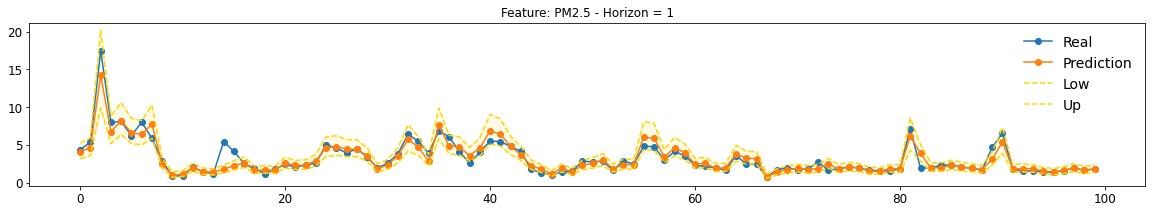

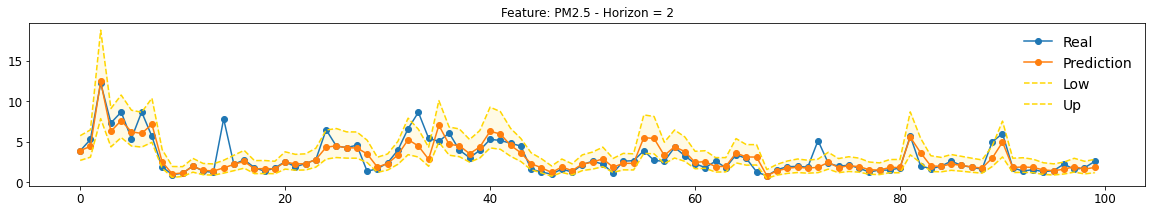

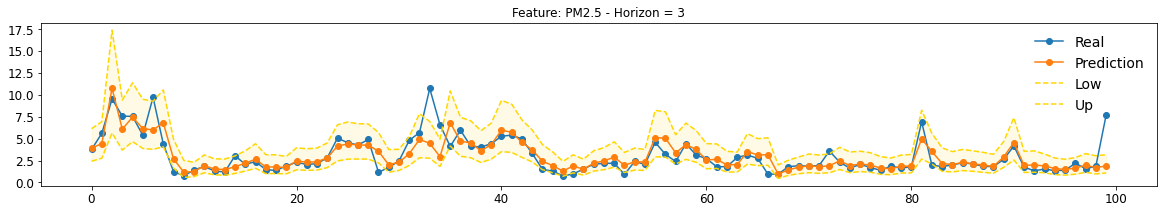

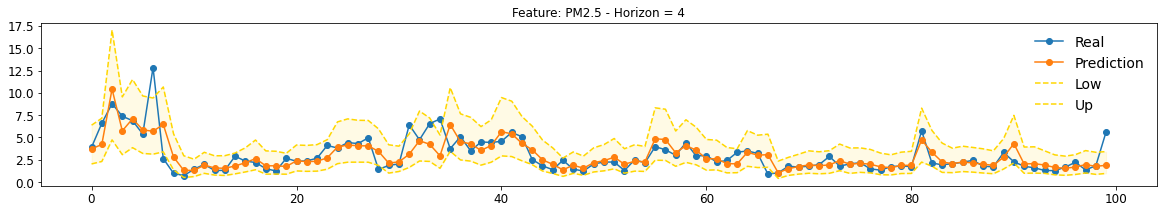

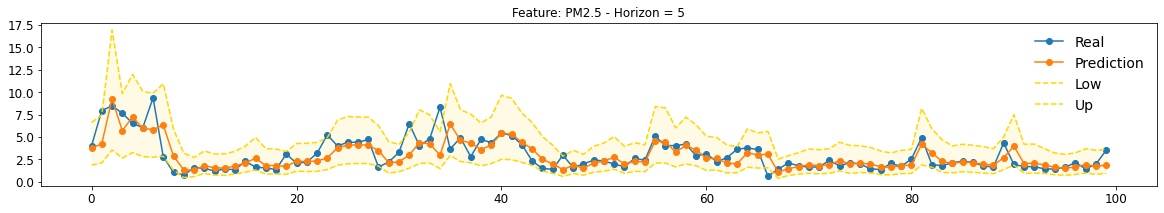

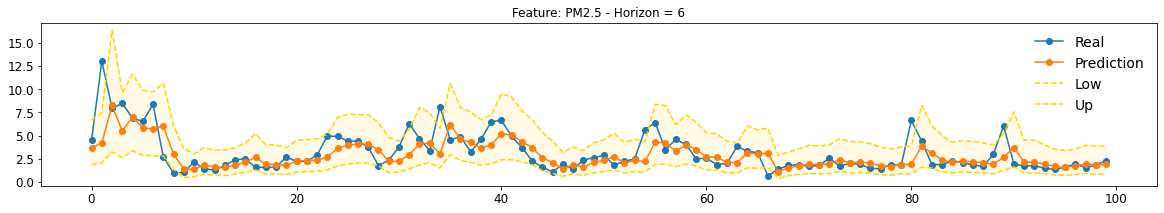

In [30]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = testY[:,  i]
    Prices['Low']        = pred[0][:, i]
    Prices['Prediction'] = pred[1][:, i]
    Prices['Up']         = pred[2][:, i]

    
    # Plot Real & Predicted values
    #
    Prices[['Real', 'Prediction']][:100].plot( figsize = (20, 3), marker = 'o' )
    
    Prices['Low'][:100].plot(color='gold', linestyle='--' )
    Prices['Up'][:100].plot(color='gold', linestyle='--' )    
    plt.fill_between(np.arange(100), Prices['Low'][:100].to_numpy(), Prices['Up'][:100].to_numpy(), color='gold', alpha=0.1)
    #
    plt.title('Feature: {} - Horizon = {}'.format(targetSeries, i+1))
    plt.legend( frameon = False, fontsize = 14)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.show()        

## Residual analysis

[INFO] Feature:  PM2.5
--------------------------------------------------


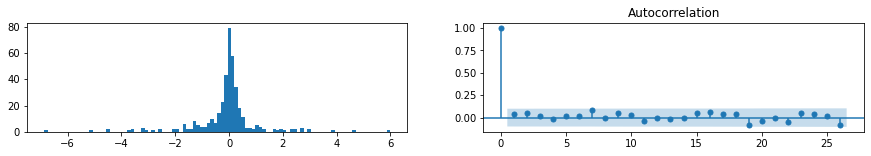

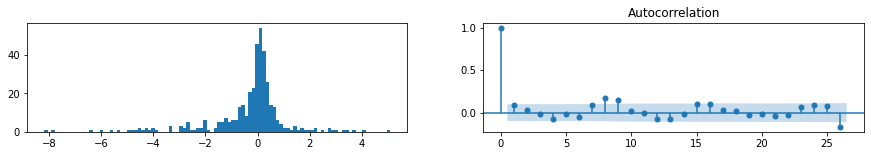

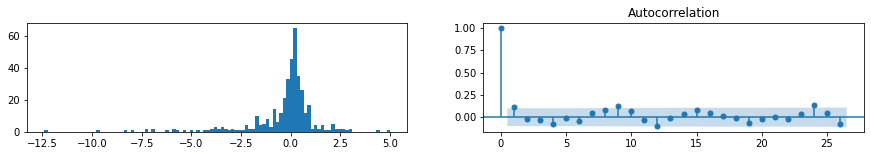

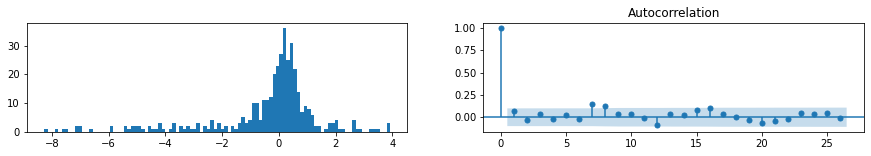

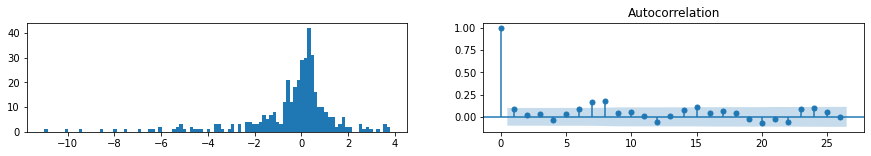

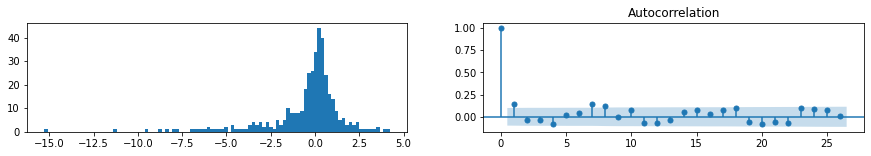

In [31]:
print('[INFO] Feature: ', targetSeries)
print(50 * '-')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = testY[:,  i]
    Prices['Prediction'] = pred[1][:, i]



            
    from scipy import stats
    from statsmodels.graphics.tsaplots import plot_acf
    
    res = (Prices['Prediction'] - Prices['Real']).to_numpy()
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 2) )

    ax[0].hist( res, bins = 100 )    
    plot_acf( res, ax=ax[1] )      

## Examples

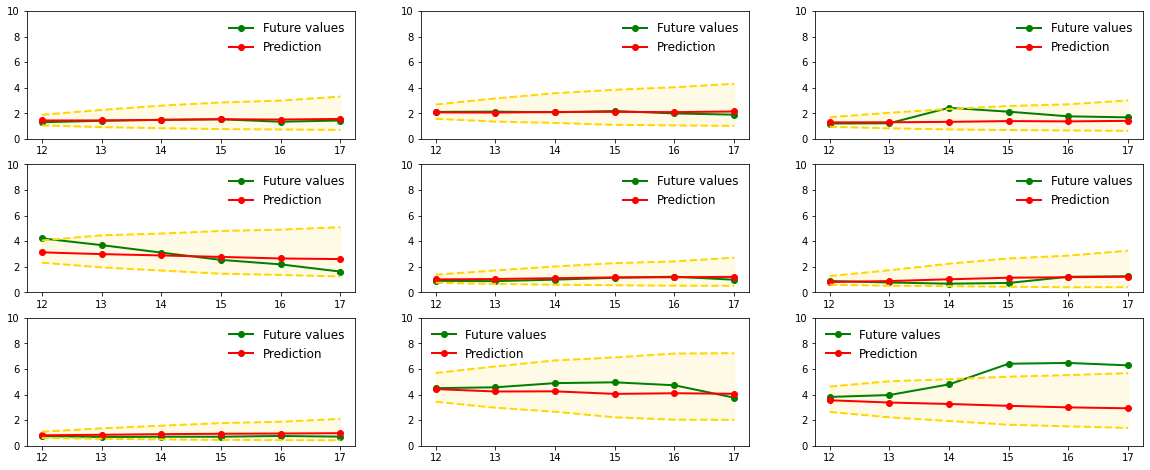

In [32]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 8) )
RandomInstances = [34, 75, 141, 325, 328, 185, 294, 27, 31]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    plt.plot(range(Lag, Lag + Horizon), testY[i], color='g', marker = 'o', linewidth = 2)
    plt.plot(range(Lag, Lag + Horizon), pred[1][i],  color='r', marker = 'o', linewidth = 2)

    plt.fill_between(range(Lag, Lag + Horizon), pred[0][i], pred[2][i], color='gold', alpha = 0.1)
    plt.plot(range(Lag, Lag + Horizon),         pred[0][i], color='gold', linestyle = '--', linewidth = 2)
    plt.plot(range(Lag, Lag + Horizon),         pred[2][i], color='gold', linestyle = '--', linewidth = 2)
    
    plt.legend(['Future values', 'Prediction'], frameon = False, fontsize = 12)
    plt.ylim([0, 12])
plt.show()

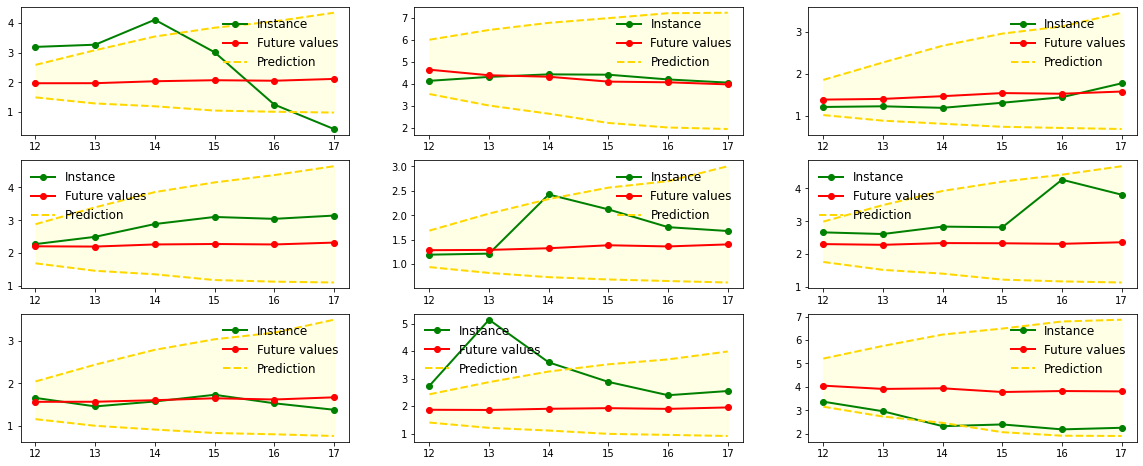

In [33]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 8) )
RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    #
    plt.plot(range(Lag, Lag + Horizon), testY[i], color='g', marker = 'o', linewidth = 2)
    plt.plot(range(Lag, Lag + Horizon), pred[1][i],  color='r', marker = 'o', linewidth = 2)

    plt.fill_between(range(Lag, Lag + Horizon), pred[0][i], pred[2][i], color='yellow', alpha = 0.1)
    plt.plot(range(Lag, Lag + Horizon),         pred[0][i], color='gold', linestyle = '--', linewidth = 2)
    plt.plot(range(Lag, Lag + Horizon),         pred[2][i], color='gold', linestyle = '--', linewidth = 2)
    
    plt.legend(['Instance', 'Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()

## Evaluation Criterion -2-

In [34]:
for horizon in range(Horizon):
    
    inLimits, outLimits = 0, 0
    
    for i in range( testY.shape[0] ):
        if (pred[0][i,horizon] <= testY[i,horizon] and testY[i,horizon] <= pred[2][i,horizon]):
            inLimits  += 1
        else:
            outLimits += 1
            
        
    print('Horizon: {}'.format( horizon+1 ))
    print(21*'-')
    print('Inside limits: {:.2f}%'.format(100*inLimits/(inLimits+outLimits)))
    print()

Horizon: 1
---------------------
Inside limits: 0.00%

Horizon: 2
---------------------
Inside limits: 0.00%

Horizon: 3
---------------------
Inside limits: 0.00%

Horizon: 4
---------------------
Inside limits: 0.00%

Horizon: 5
---------------------
Inside limits: 0.00%

Horizon: 6
---------------------
Inside limits: 0.00%

